In [1]:
import os.path as op
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import numpy as np
from scipy.io import loadmat
from scipy.stats import ttest_rel, ttest_ind

from neurodsp.filt import filter_signal
from neurodsp.utils.norm import normalize_sig

from timescales.mp import compute_taus
from timescales.plts import plot_connected_scatter
from timescales.utils import create_windows, get_distinct_windows

### Sliding Window Tau

#### Background
This notebook uses hippocampal recordings from fcx-1 to investigate sliding window tau estimation. This data consists of 1-2 cycles, each containing ~7 minutes of wake followed by ~20 minutes of sleep. Based on Watson at al. 2016, they show that overall power increases (high variance voltage segments) during non-REM episodes. CRCNS provides times of sleep, non-rem, rem, and micro-arousals. Here, we focus on comparing timescales between sleep vs non-rem, since rem and micro arousals periods contain much less data.


#### Method / Results
For the ~54 minutes of interest, a window is slide across the data, with a step size of 2s. Each window contains 20s before and after the current sample. Windows are grouped by wake and non-REM sleep periods. A Welch's PSD is computed for each window, and a timescale is determined using both ACF and SpecParam. The results suggest that timescales to become longer during wake compared to non-rem. Furthermore, SpecParam produces more accurate fits than ACF fitting - possibly resulting in greater ACF timescale variance.

The Watson reference below attributes broadband theta power in non-rem periods to oscillations. However, the mean non-rem ACF contains a lower variance cosine component, compared to the wake periods. This may be due to wider range of low frequency oscillations due to a broader bandwidth, and mis-alignment in the ACF. Are the aperiodic knee fits truly aperiodic, or is some of the low frequency power oscillations?


#### Reference
Network Homeostasis and State Dynamics of Neocortical Sleep. Watson BO, Levenstein D, Greene JP, Gelinas JN, Buzsáki G.; Neuron. 2016 Apr 27. pii: S0896-6273(16)30056-3. doi: 10.1016/j.neuron.2016.03.036

In [2]:
# Load LFP
data_id = '20140526_277um'
data_dir = f'/home/rph/Projects/timescale-methods/fcx1/data_mats/{data_id}'

fs = 1250

# Take mean of all hippocampal channels
channels = [*list(range(64, 68)), *list(range(76, 84)), *list(range(92, 96))]

lfp_file = op.join(data_dir, 'data01.mat')
sig_lfp = loadmat(lfp_file)['data'][0]
sig_lfp = np.zeros((len(channels), len(sig_lfp)))

for cind, ch in enumerate(channels):
    lfp_file = op.join(data_dir, f'data{ch}.mat')
    _sig_lfp = normalize_sig(loadmat(lfp_file)['data'][0], mean=0, variance=1)
    sig_lfp[cind] = _sig_lfp
del _sig_lfp

sig_lfp = np.median(sig_lfp, axis=0)
times = np.arange(0, len(sig_lfp)/fs, 1/fs)

# Extract behavioral data
beh_file = op.join(data_dir, f'{data_id}_WSRestrictedIntervals.mat')

beh = loadmat(beh_file)

nrem = beh['SWSPacketTimePairFormat'].astype(int) * fs
wake = beh['WakeTimePairFormat'].astype(int) * fs
rem = beh['REMTimePairFormat'].astype(int) * fs

In [3]:
# Settings
win_len = int(2*fs)
win_spacing = int(2*fs)

# Remove edges to reduce edge trial edge effects
wake_pad = wake.copy()
wake_pad[:, 0] = wake_pad[:, 0] + win_len
wake_pad[:, 1] = wake_pad[:, 1] - win_len

nrem_pad = nrem.copy()
nrem_pad[:, 0] = nrem_pad[:, 0] + win_len
nrem_pad[:, 1] = nrem_pad[:, 1] - win_len

# Create spectral windows
wake_starts, wake_mids, wake_ends = create_windows(wake_pad, win_len, win_spacing)
nrem_starts, nrem_mids, nrem_ends = create_windows(nrem_pad, win_len, win_spacing)

# Get non-overlapping windows - for independence in stats
wake_starts_noover, wake_ends_noover = get_distinct_windows(wake_starts, wake_ends)
nrem_starts_noover, nrem_ends_noover = get_distinct_windows(nrem_starts, nrem_ends)

### SpecParam

In [4]:
fooof_kwargs = dict(knee_bounds=(.2, 40), max_n_peaks=3,
                    peak_threshold=3, peak_width_limits=(2, 10))

#compute_spectrum_kwargs = dict(method='welch', avg_type='mean', nperseg=int(1 * fs))
compute_spectrum_kwargs = dict(method='multitaper')

fit_kwargs = dict(
    sig=sig_lfp,
    fs=fs,
    win_len=win_len,
    f_range=(.2, 40),
    compute_spectrum_kwargs=compute_spectrum_kwargs,
    fit_kwargs=fooof_kwargs,
    rsq_type='linear'
)

wake_taus, wake_rsq, wake_fms = compute_taus(wake_starts, method='psd', fit_kwargs=fit_kwargs)
nrem_taus, nrem_rsq, nrem_fms = compute_taus(nrem_starts, method='psd', fit_kwargs=fit_kwargs)

  0%|          | 0/1067 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

### ACF

In [5]:
# ACF

# Set bounds and guess as :
#   [exp_tau, osc_tau, osc_gamma, osc_freq, amp_ratio, height, offset]
bounds = [
    [1/(2*np.pi*40), .001,  0,   0, 0, .5, 0],
    [1/(2*np.pi*.2),    1, .1,  20, 1,  1, .1]
]

fit_kwargs = dict(
    sig = sig_lfp,
    fs = fs,
    win_len = win_len,
    method = 'cos',
    compute_acf_kwargs = dict(nlags=int(.5 * fs)),
    fit_kwargs = dict(maxfev=10000, bounds=bounds)
)

wake_taus_acf, wake_rsq_acf, wake_acf_class = compute_taus(wake_starts, method='acf',
                                                           fit_kwargs=fit_kwargs, low_mem=True)
nrem_taus_acf, nrem_rsq_acf, nrem_acf_class = compute_taus(nrem_starts, method='acf',
                                                           fit_kwargs=fit_kwargs, low_mem=True)

  0%|          | 0/1067 [00:00<?, ?it/s]

  0%|          | 0/1330 [00:00<?, ?it/s]

### Results

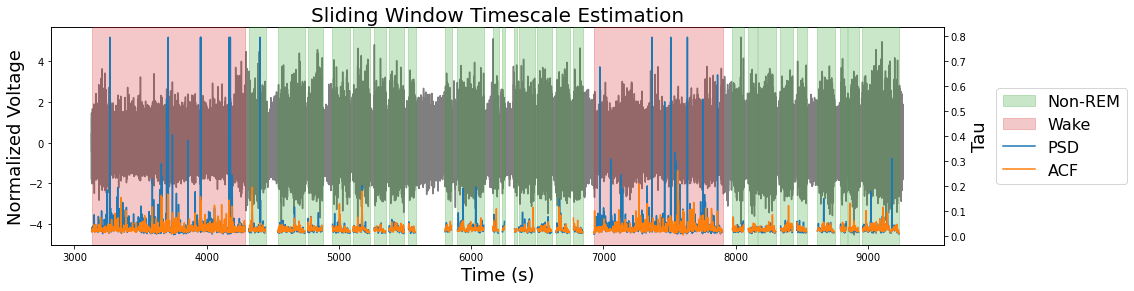

In [6]:
fig, ax0 = plt.subplots(figsize=(16, 4))

# Determine start and end of lfp
start_ends = [nrem[0][0], nrem[-1][-1], rem[0][0],
              rem[-1][-1], wake[0][0], wake[-1][-1]]

start = min(start_ends)-1
end = max(start_ends)

# Color regions
colors = ['C2', 'C3']
labels = ['Non-REM', 'Wake']


inds = np.where((times > start/fs) & (times < end/fs))[0]
plt.plot(times[inds], sig_lfp[inds], color='k', alpha=.5)

ax1 = ax0.twinx()
ax1.set_ylabel('Tau')
ax1.tick_params(axis='y')

for periods, color, label in zip([nrem, wake], colors, labels):
    for _ind, i in enumerate(periods):
        if _ind == 0:
            plt.axvspan(i[0]/fs, i[1]/fs, alpha=.25, color=color, zorder=3, label=label)
        else:
            plt.axvspan(i[0]/fs, i[1]/fs, alpha=.25, color=color, zorder=3)
            


_zipped_params = zip([wake_mids, nrem_mids], [wake_taus, nrem_taus], [wake_taus_acf, nrem_taus_acf])

plt_labels = True

for _mids, _taus, _taus_acf in _zipped_params:
    
    spacing = np.diff(_mids)[0]
    
    split_inds = np.where(np.diff(_mids) != spacing)[0] + 1
    inds = np.arange(len(_mids), dtype=int)

    split_inds = np.split(inds, split_inds)
    
    for arr in split_inds:
        

        if plt_labels:
            ax1.plot(times[_mids[arr]], _taus[arr], color='C0', zorder=10, label='PSD')
            ax1.plot(times[_mids[arr]], _taus_acf[arr], color='C1', zorder=10, label='ACF')
            plt_labels=False
        else:
            ax1.plot(times[_mids[arr]], _taus[arr], color='C0', zorder=10)
            ax1.plot(times[_mids[arr]], _taus_acf[arr], color='C1', zorder=10)

#ax1.set_ylim(0, .2)

ax0.set_xlabel('Time (s)', size=18)
ax0.set_ylabel('Normalized Voltage', size=18)
ax1.set_ylabel('Tau', size=18)

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=16);

plt.title('Sliding Window Timescale Estimation', size=20)
plt.savefig('fig_ts_125dpi.png', dpi=125, bbox_inches='tight');

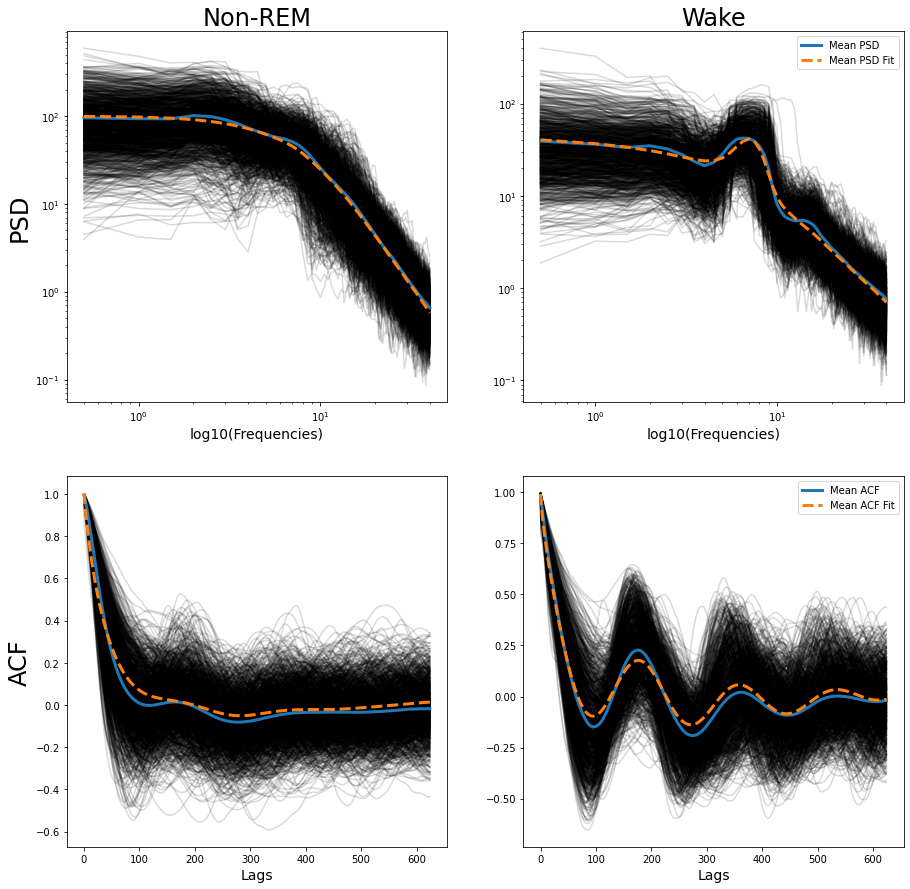

In [7]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)


# Each spectra/acf
nrem_inds = [ind for ind, start in enumerate(nrem_starts)
             if start in nrem_starts_noover]

wake_inds = [ind for ind, start in enumerate(wake_starts)
             if start in wake_starts_noover]

alpha = .15

for ind, _fm in enumerate(nrem_fms):
    if ind in nrem_inds:
        axes[0][0].loglog(_fm.freqs, 10**_fm.power_spectrum, color='k', alpha=alpha)
        
for ind, _acf in enumerate(np.array([i.corrs for i in nrem_acf_class])):
    if ind in nrem_inds:
        axes[1][0].plot(_acf, color='k', alpha=alpha)
        
for ind, _fm in enumerate(wake_fms):
    if ind in wake_inds:
        axes[0][1].loglog(_fm.freqs, 10**_fm.power_spectrum, color='k', alpha=alpha)

for ind, _acf in enumerate(np.array([i.corrs for i in wake_acf_class])):
    if ind in wake_inds:
        axes[1][1].plot(_acf, color='k', alpha=alpha)
    
# Mean spectra/acf
freqs = nrem_fms[0].freqs

nrem_power = np.mean(np.array([10**_fm.power_spectrum for ind, _fm in enumerate(nrem_fms)
                               if ind in nrem_inds]), axis=0)
wake_power = np.mean(np.array([10**_fm.power_spectrum for ind, _fm in enumerate(wake_fms)
                               if ind in wake_inds]), axis=0)

nrem_power_fit = np.mean(np.array([10**_fm.fooofed_spectrum_ for ind, _fm in enumerate(nrem_fms)
                                   if ind in nrem_inds]), axis=0)
wake_power_fit = np.mean(np.array([10**_fm.fooofed_spectrum_ for ind, _fm in enumerate(wake_fms)
                                   if ind in wake_inds]), axis=0)

nrem_corrs = np.mean(np.array([c.corrs for ind, c in enumerate(nrem_acf_class)
                               if ind in nrem_inds]), axis=0)
 
wake_corrs = np.mean(np.array([c.corrs for ind, c in enumerate(wake_acf_class)
                               if ind in wake_inds]), axis=0)


nrem_corrs_fit = np.mean(np.array([c.gen_corrs_fit() for ind, c in enumerate(nrem_acf_class)
                               if ind in nrem_inds]), axis=0)
 
wake_corrs_fit = np.mean(np.array([c.gen_corrs_fit() for ind, c in enumerate(wake_acf_class)
                               if ind in wake_inds]), axis=0)

# Plot mean power/acf
lw = 3

axes[0][0].plot(freqs, nrem_power, color='C0', lw=lw)
axes[0][1].plot(freqs, wake_power, color='C0', lw=lw, label='Mean PSD')
                     
axes[1][0].plot(nrem_corrs, color='C0', lw=lw)
axes[1][1].plot(wake_corrs, color='C0', lw=lw, label='Mean ACF')
    
# Plot mean fits
axes[0][0].plot(freqs, nrem_power_fit, color='C1',ls='--', lw=lw)
axes[0][1].plot(freqs, wake_power_fit,  color='C1', ls='--', lw=lw, label='Mean PSD Fit')
axes[1][0].plot(nrem_corrs_fit, color='C1', ls='--', lw=lw)
axes[1][1].plot(wake_corrs_fit, color='C1', ls='--', lw=lw, label='Mean ACF Fit')

axes[0][0].set_title('Non-REM', size=24)
axes[0][1].set_title('Wake', size=24)
axes[0][0].set_ylabel('PSD', size=24)
axes[1][0].set_ylabel('ACF', size=24)


axes[0][0].set_xlabel('log10(Frequencies)', size=14)
axes[0][1].set_xlabel('log10(Frequencies)', size=14)

axes[1][0].set_xlabel('Lags', size=14)
axes[1][1].set_xlabel('Lags', size=14)

axes[0][1].legend()
axes[1][1].legend();

plt.savefig('fig_fit_125dpi.png', dpi=125)

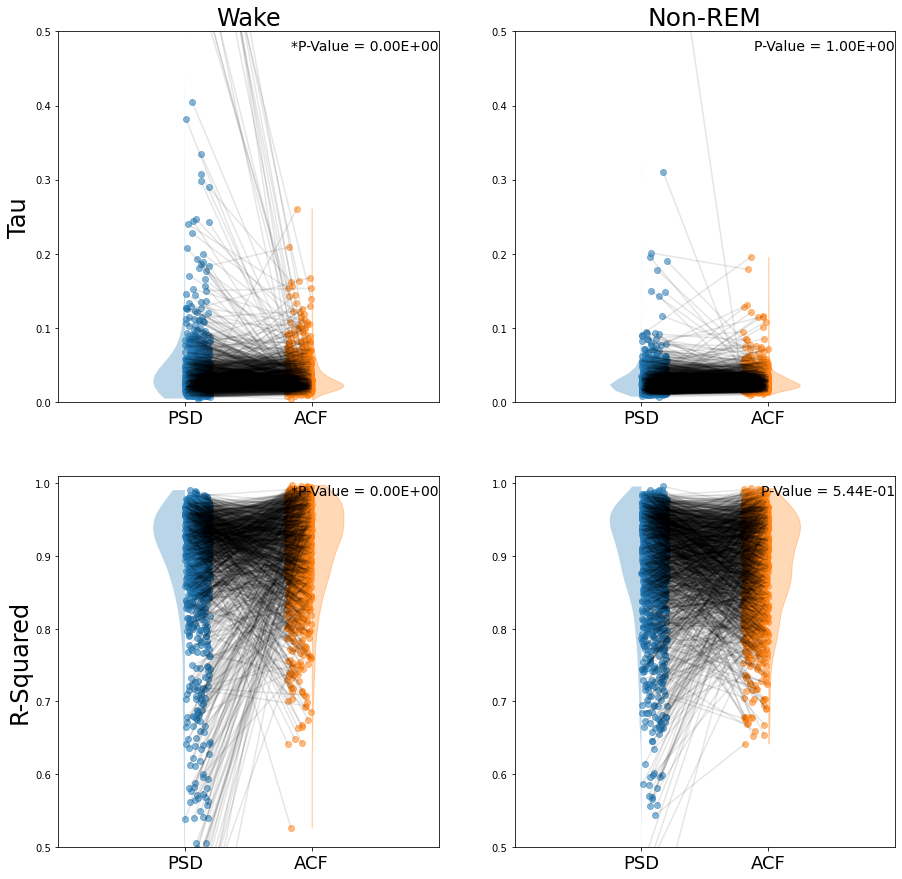

In [11]:
# Run paired t-test
wake_rsq_pval = ttest_rel(wake_rsq[wake_inds], wake_rsq_acf[wake_inds]).pvalue
wake_taus_pval = ttest_rel(wake_taus[wake_inds], wake_taus_acf[wake_inds]).pvalue

nrem_rsq_pval = ttest_rel(nrem_rsq[nrem_inds], nrem_rsq_acf[nrem_inds]).pvalue
nrem_taus_pval = ttest_rel(nrem_taus[nrem_inds], nrem_taus_acf[nrem_inds]).pvalue

# Plot
alpha = .1
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

ax0 = plot_connected_scatter(wake_taus[wake_inds], wake_taus_acf[wake_inds], axes[0][0],
                             f'Wake Tau: PSD vs ACF\nPaired T-Test P-Value = {wake_taus_pval}',
                             alpha_line=alpha, ylim=(0, .5))

ax1 = plot_connected_scatter(nrem_taus[nrem_inds], nrem_taus_acf[nrem_inds], axes[0][1],
                             f'Non-REM Tau: PSD vs ACF\nPaired T-Test P-Value = {nrem_taus_pval}',
                             alpha_line=alpha, ylim=(0, .5))

ax2 = plot_connected_scatter(wake_rsq[wake_inds], wake_rsq_acf[wake_inds], axes[1][0],
                             title=f'Wake R^2: PSD vs ACF\nPaired T-Test P-Value = {wake_rsq_pval}',
                             alpha_line=alpha, ylim=(0.5, 1.01))

ax3 = plot_connected_scatter(nrem_rsq[nrem_inds], nrem_rsq_acf[nrem_inds], axes[1][1],
                             title=f'Non-REM R^2: PSD vs ACF\nPaired T-Test P-Value = {nrem_rsq_pval}',
                             alpha_line=alpha, ylim=(0.5, 1.01))

# Custom labels
ax0.set_ylabel('Tau', size=24)
ax1.set_ylabel('')
ax2.set_ylabel('R-Squared', size=24)
ax3.set_ylabel('', size=24)

for _ax, pval in zip([ax0, ax1, ax2, ax3], [wake_taus_pval, nrem_taus_pval, wake_rsq_pval, nrem_rsq_pval]):
    
    _ax.set_xticklabels(['PSD', 'ACF'], fontsize=18)
    
    _ax_in = _ax.inset_axes([0, .8, 1, 0.2])
    _ax_in.xaxis.set_visible(False)
    _ax_in.yaxis.set_visible(False)
    
    if pval < .05:
        _ax_in.text(1, .8, f'*P-Value = {pval.round(8):.2E}', size=14, ha='right', va='center')
    else:
        _ax_in.text(1, .8, f'P-Value = {pval.round(8):.2E}', size=14, ha='right', va='center')
    _ax_in.axis('off')
    
    
ax0.set_title('Wake', size=24)
ax1.set_title('Non-REM', size=25)
ax2.set_title('')
ax3.set_title('')


plt.savefig('fig_scatter_125dpi.png', dpi=125)

<AxesSubplot:title={'center':'ACF R^2\nInd T-Test P-Value = 2.9030832198309342e-12'}, ylabel='R^2'>

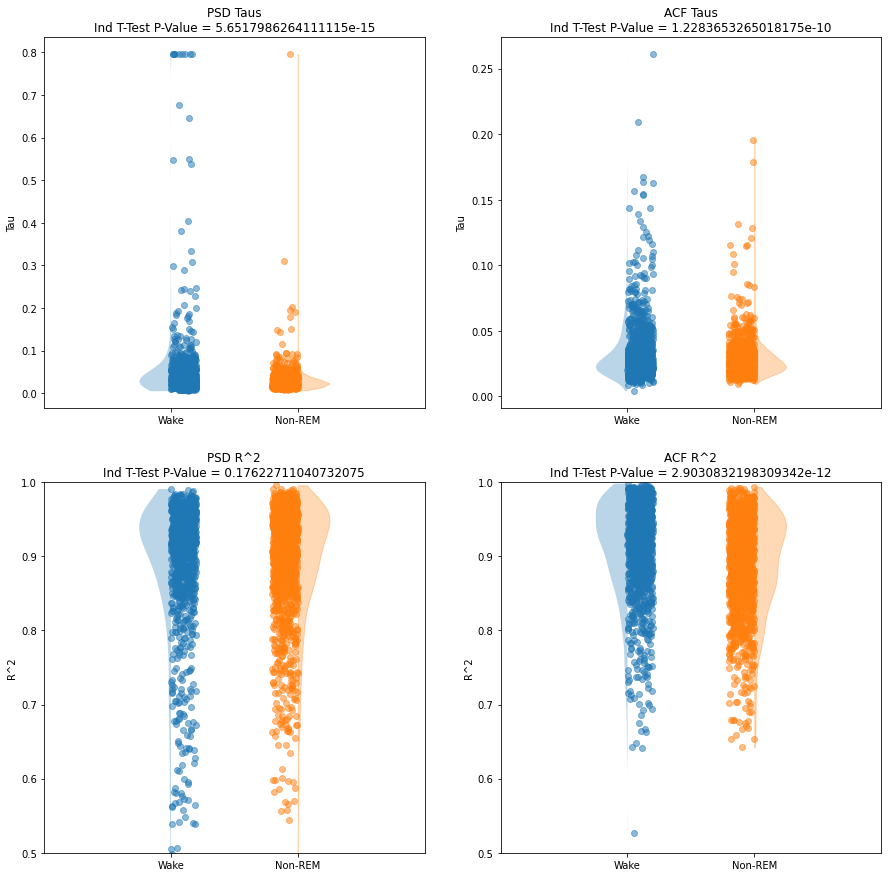

In [9]:
# Run ind t-test
psd_taus_pval = ttest_ind(wake_taus, nrem_taus).pvalue
psd_rsq_pval = ttest_ind(wake_rsq, nrem_rsq).pvalue

acf_taus_pval = ttest_ind(wake_taus_acf[wake_inds], nrem_taus_acf[nrem_inds]).pvalue
acf_rsq_pval = ttest_ind(wake_rsq_acf[wake_inds], nrem_rsq_acf[nrem_inds]).pvalue

# Plot
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))

plot_connected_scatter(wake_taus[wake_inds], nrem_taus[nrem_inds], axes[0][0], 
                       f'PSD Taus\nInd T-Test P-Value = {psd_taus_pval}',
                       ticklabels=['Wake', 'Non-REM'], paired=False)

plot_connected_scatter(wake_taus_acf[wake_inds], nrem_taus_acf[nrem_inds], axes[0][1],
                       f'ACF Taus\nInd T-Test P-Value = {acf_taus_pval}',
                       ticklabels=['Wake', 'Non-REM'], paired=False)

plot_connected_scatter(wake_rsq[wake_inds], nrem_rsq[nrem_inds], axes[1][0],
                       title=f'PSD R^2\nInd T-Test P-Value = {psd_rsq_pval}',
                       ylim=(.5, 1), ylabel='R^2', ticklabels=['Wake', 'Non-REM'], paired=False)

plot_connected_scatter(wake_rsq_acf[wake_inds], nrem_rsq_acf[nrem_inds], axes[1][1],
                       title=f'ACF R^2\nInd T-Test P-Value = {acf_rsq_pval}',
                       ylim=(.5, 1), ylabel='R^2', ticklabels=['Wake', 'Non-REM'], paired=False)